In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import ast

In [4]:
movies = pd.read_csv("movies_metadata.csv", sep=",")
movies.head(4)

C:\Users\Albert\AppData\Local\Temp\ipykernel_5708\733899630.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv", sep=",")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0


<h1>Preprocesamiento de datos</h1>

In [5]:
#Este código transforma la columna genres, que originalmente podría contener cadenas que representan listas de diccionarios, en una lista real de nombres de géneros.

movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
#Selecciono las columnas que me interesan y  muestroel tipo de dato de cada columna. Es útil para tener una visión general de la estructura del datsaet.

movies = movies[['id','title','overview','genres','vote_count','vote_average', 'release_date']]

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45466 non-null  object 
 1   title         45460 non-null  object 
 2   overview      44512 non-null  object 
 3   genres        45466 non-null  object 
 4   vote_count    45460 non-null  float64
 5   vote_average  45460 non-null  float64
 6   release_date  45379 non-null  object 
dtypes: float64(2), object(5)
memory usage: 2.4+ MB


In [7]:
#Miro a ver cuantos valores nulos hay
movies.isnull().sum()

id                0
title             6
overview        954
genres            0
vote_count        6
vote_average      6
release_date     87
dtype: int64

In [8]:
#Elimino todas las filas que contienen al menos un valor nulo.

movies.dropna(inplace=True)

movies.head()

,id,title,overview,genres,vote_count,vote_average,release_date
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",5415.0,7.7,1995-10-30
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",2413.0,6.9,1995-12-15
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]",92.0,6.5,1995-12-22
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",34.0,6.1,1995-12-22
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy],173.0,5.7,1995-02-10


<h1>Sistema de recomendación</h1>

In [9]:
#Ahora necesitamos una métrica para puntuar o calificar las películas.Como no es lo mismo una película con 3
#votos y una puntuacióin de 9 que una pelicula con 3000 votos y una puntuación de 7, usare la formula de IMDB. Que es la siguiente
#Weighted Rating(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C . Donde
#v es el número de votos para la película;
#m es el número mínimo de votos requeridos para aparecer en la lista;
#R es la calificación promedio de la película
#C es el voto promedio en todo el informe.

#Ya tengo v  y R. Ahora toca calcular C(voto promedio) 

In [10]:
C = movies['vote_average'].mean()
C

5.6438190615502934

In [11]:
# Ahora hay que encontrar un valor para "m", es decir, el número mínimo de votos necesarios para aparecer en la lista. 
#Utilizaré el percentil 90 como  punto de corte. Es decir, para que una película aparezca en las listas, debe tener más votos que al menos el 90% de las películas en la lista.
m= movies['vote_count'].quantile(0.95)
m

447.0

In [12]:
#Ahora creo un nuevo DataFrame movielist que contiene solo las películas que tienen un número de votos mayor o igual a m

movielist = movies.copy().loc[movies['vote_count'] >= m]
movielist.shape

(2225, 7)

In [13]:
movielist.head(3)

,id,title,overview,genres,vote_count,vote_average,release_date
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",5415.0,7.7,1995-10-30
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",2413.0,6.9,1995-12-15
5,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[Action, Crime, Drama, Thriller]",1886.0,7.7,1995-12-15


In [15]:
#Hay 2225 películas que califican para estar en esta lista. Ahora, hay que calcular la  métrica para cada
#película. Para hacer esto, definiré una función llamada "weighted_rating()" usando la formula de IMDB.

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
# Aplico la función weighted_rating a cada fila del DataFrame movielist y almaceno el resultado en una nueva columna llamada 'score'.

movielist['score'] = movielist.apply(weighted_rating, axis=1)

In [17]:
#Filtro las peliculas segun el valor score de mayor a menor.

movielist = movielist.sort_values('score', ascending=False)

#Print the top 15 movies
movielist[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.355001
834,The Godfather,6024.0,8.5,8.302702
12481,The Dark Knight,12269.0,8.3,8.206628
2843,Fight Club,9678.0,8.3,8.182735
292,Pulp Fiction,8670.0,8.3,8.169769
351,Forrest Gump,8147.0,8.2,8.067045
522,Schindler's List,4436.0,8.3,8.056848
23673,Whiplash,4376.0,8.3,8.053823
5481,Spirited Away,3968.0,8.3,8.031073
15480,Inception,14075.0,8.1,8.024397


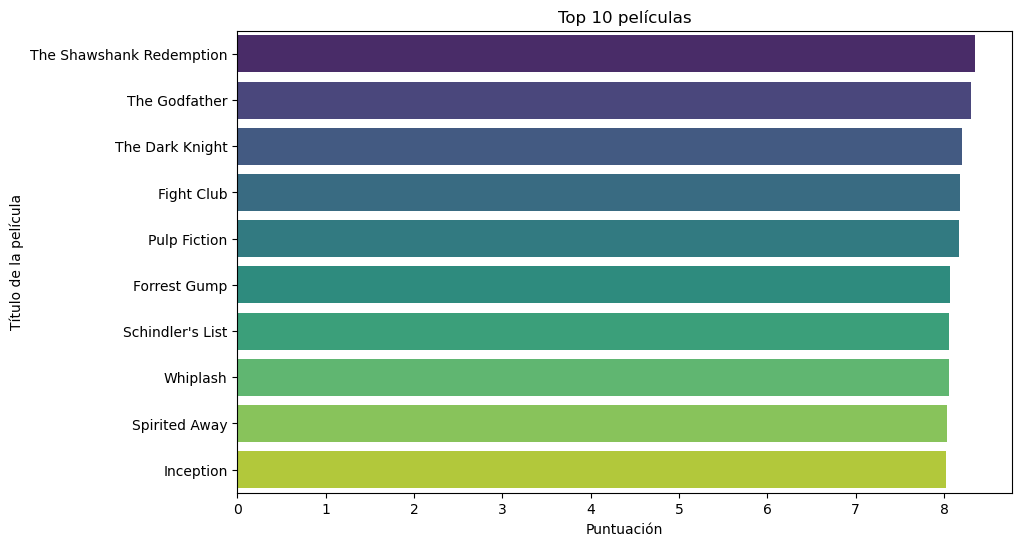

In [18]:
# Lo muestro de manera grafica según el Score

top_n = 10

plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='title', data=movielist.head(top_n), palette='viridis')
plt.title(f'Top {top_n} películas')
plt.xlabel('Puntuación')
plt.ylabel('Título de la película')
plt.show()


<h1>Recomendaciones por genero</h1>

In [19]:
#La función get_genre_recommendations toma un género y un número de recomendaciones como entrada. Filtra las películas en el DataFrame movielist que
#pertenecen al género especificado, las ordena por puntuación en orden desdecente y devuelve las películas recomendadas para ese género.
#la función main llama a get_genre_recommendations especificando un género(en este caso, 'Horror') y muestra las recomendaciones. 

def get_genre_recommendations(genre, num_recommendations=10):
    # Filtrar películas por el género especificado
    genre_movies = movielist[movielist['genres'].apply(lambda x: genre in x)]
    
    # Ordenar películas por puntuación
    genre_movies = genre_movies.sort_values('score', ascending=False)
    
    # Mostrar las primeras 'recommendations' películas recomendadas
    recommendations = genre_movies[['title', 'vote_count', 'vote_average', 'score']].head(num_recommendations)
    
    return recommendations


def main():
    # Llama a la función con el género deseado y muestra las recomendaciones
    genre = 'Comedy'  # Se puede cambiar al género que se desee como 'Romance', 'Thriller', 'Horror', etc.
    recommendations = get_genre_recommendations(genre, num_recommendations=10)
    
    print(f"Recomendaciones de películas en el género '{genre}':")
    print(recommendations)

if __name__ == "__main__":
    main()

Recomendaciones de películas en el género 'Comedy':
                             title  vote_count  vote_average     score
351                   Forrest Gump      8147.0           8.2  8.067045
2211             Life Is Beautiful      3643.0           8.3  8.009703
18465             The Intouchables      5410.0           8.2  8.004915
1225            Back to the Future      6239.0           8.0  7.842475
22841     The Grand Budapest Hotel      4644.0           8.0  7.793123
22131      The Wolf of Wall Street      6768.0           7.9  7.760220
30315                   Inside Out      6737.0           7.9  7.759617
40882                   La La Land      4745.0           7.9  7.705756
10309  Dilwale Dulhania Le Jayenge       661.0           9.1  7.705674
13724                           Up      7048.0           7.8  7.671406


<h1>Recomendacions segun el contenido </h1>

In [20]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval
import numpy as np
# Carga de datos
credits = pd.read_csv('credits.csv')
credits.head(3)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


In [21]:
print(movielist['id'].dtype)
print(credits['id'].dtype)

object
int64


In [22]:
# Verificar si hay valores no numéricos
non_numeric_ids = pd.to_numeric(movielist['id'], errors='coerce').isna()
print(movielist[non_numeric_ids])

Empty DataFrame
Columns: [id, title, overview, genres, vote_count, vote_average, release_date, score]
Index: []


In [23]:
# Eliminar duplicados mantiendo la primera de las filas duplicadas.
movies = movies.drop_duplicates(subset='id', keep='first')
movies = movies.drop_duplicates(subset='title', keep='first')

In [24]:
movielist.head(3)

,id,title,overview,genres,vote_count,vote_average,release_date,score
314,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,"[Drama, Crime]",8358.0,8.5,1994-09-23,8.355001
834,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[Drama, Crime]",6024.0,8.5,1972-03-14,8.302702
12481,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]",12269.0,8.3,2008-07-16,8.206628


In [25]:
#Primero, convierto la columna 'release_date' a objetos de tipo datetime. Si hay errores en la conversión (como fechas no válidas), se reemplazan por NaN
#Luego, aplica una función lambda para extraer el año de cada fecha. Si la fecha es válida, se convierte en una cadena y se divide a partir del guion para extraer el año. 
#Si la fecha es NaN, simplemente devuelve NaN.

movielist['year'] = pd.to_datetime(movielist['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

 

In [26]:
movielist.head(3)

,id,title,overview,genres,vote_count,vote_average,release_date,score,year
314,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,"[Drama, Crime]",8358.0,8.5,1994-09-23,8.355001,1994
834,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[Drama, Crime]",6024.0,8.5,1972-03-14,8.302702,1972
12481,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]",12269.0,8.3,2008-07-16,8.206628,2008


In [27]:
# Convertir la columna 'id' en movies a int64 para futuras operaciones y garantizar la coherencia con credits.
movielist['id'] = movielist['id'].astype('int64')

# Verificar los tipos de datos de 'id' en ambos DataFrames
print(movielist['id'].dtype)
print(credits['id'].dtype)

int64
int64


In [28]:
#combino la información de credits y movielist en el dataset merge_df,  basándose en el identificador de película.

merged_df = movielist.merge(credits, on='id')


In [29]:
merged_df.head(3)

,id,title,overview,genres,vote_count,vote_average,release_date,score,year,cast,crew
0,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,"[Drama, Crime]",8358.0,8.5,1994-09-23,8.355001,1994,"[{'cast_id': 3, 'character': 'Andy Dufresne', ...","[{'credit_id': '52fe4231c3a36847f800b127', 'de..."
1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[Drama, Crime]",6024.0,8.5,1972-03-14,8.302702,1972,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de..."
2,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]",12269.0,8.3,2008-07-16,8.206628,2008,"[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de..."


In [30]:
# Se aplica la función literal_eval a cada elemento de esas columnas usando .apply(). 
#Esto conviertelistas y diccionarios en objeto reales en Python.

features = ['cast', 'crew']
for feature in features:
    merged_df[feature] = merged_df[feature].apply(literal_eval)  

In [31]:
#Defino la funcion clean_data para procesar y limpiar información y la funcion get_directos para extraer y limpiar el nombre del director.

def clean_data(x):
    if isinstance(x, list):
        cleaned_list = []
        for i in x:
            if isinstance(i, dict) and 'name' in i:
                cleaned_list.append(str.lower(i['name'].replace(" ", "")))
            else:
                print(f"Unexpected value: {i}")  # Imprimir valores inesperados
        return cleaned_list
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name'].replace(" ", "").lower()  # Extraer el nombre del director que esta bajo la llave 'name'
    return ''

In [32]:
# Obteniendo el nombre del director y almacenándolo en una nueva columna

merged_df['director'] = merged_df['crew'].apply(get_director)

features_clean = ['cast', 'director', 'overview']

# AplicÓ la función clean_data a cada columna en features_clean para limpiar la información.

for feature in features_clean:
    merged_df[feature] = merged_df[feature].apply(clean_data)


In [33]:
#Creo una representación combinada de características relevantes para cada película.
def create_soup(x):
    return ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) + ' ' + x['overview']

# Crear el 'soup' para cada película
merged_df['soup'] = merged_df.apply(create_soup, axis=1)

In [34]:
# Utilizar TfidfVectorizer para crear la matriz de características, ignorando las stop words.
tfidf = TfidfVectorizer(stop_words='english') 
tfidf_matrix = tfidf.fit_transform(merged_df['soup'])

# Calcular la matriz de similitud de coseno entre las peliculas.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [35]:
# Reseteo índices y hago una serie que mapea títulos de películas a índices en el DataFrame. Indices es una Serie que actúa
#como un diccionario donde las claves son títulos de películas y los valores son los índices de esas películas 


merged_df = merged_df.reset_index()
indices = pd.Series(merged_df.index, index=merged_df['title'])

In [36]:
#Defino get_recommnedations para recomendar películas basadas en la similitud del contenido.

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11] 
    movie_indices = [i[0] for i in sim_scores]
    return merged_df['title'].iloc[movie_indices]

In [37]:
get_recommendations('The Ring', cosine_sim)

2038                   The Ring Two
949                           Rango
1678    The Texas Chainsaw Massacre
1463        The Autopsy of Jane Doe
1735           Terminator Salvation
2130                Jennifer's Body
105                    Donnie Darko
762               Kramer vs. Kramer
558                   Lilo & Stitch
1539                    Funny Games
Name: title, dtype: object

In [38]:
#Las recomendaciones estan bien pero son algo evidentes, y por otro lado, Lilo&Stitch y Kramervs Kramer son recomendaciones
#que poco o nada tienen que ver con The Ring

In [39]:
#Proporciona recomendaciones mejoradas al tener en cuenta tanto la similitud del contenido como el género de las películas.
#La función inicia de manera similar a get_recommendations obteniendo las puntuaciones de similitud para cada película.
#Luego, modifica estas puntuaciones en función de los géneros de las películas.
#Finalmente, filtra las películas recomendadas basadas en votos y calificaciones, y aplica el rating ponderado.


def improved_recommendations(title, gender_weight=0.1):
    # Obtener el índice de la película
    idx = indices[title]
    
    # Obtener las puntuaciones de similitud
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Obtener los géneros de la película de entrada
    target_genres = set(merged_df.loc[idx, 'genres'])
    
    # Modificar las puntuaciones de similitud en función de los géneros
    for i in range(len(sim_scores)):
        current_idx = sim_scores[i][0]
        current_genres = set(merged_df.loc[current_idx, 'genres'])
        if target_genres.intersection(current_genres):
            sim_scores[i] = (sim_scores[i][0], sim_scores[i][1] + gender_weight)
    

    # Ordenar las películas basándose en las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener las 25 películas más similares
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    # Obtener detalles de estas películas
    movies = merged_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    
    # Filtrar películas que tienen votos y calificaciones no nulas
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & 
                   (movies['vote_count'].notnull()) & 
                   (movies['vote_average'].notnull())].copy()
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    # Calcular el rating ponderado y devolver las 10 primeras películas
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified


In [40]:
improved_recommendations('The Ring')

,title,vote_count,vote_average,year,wr
250,The Bourne Identity,3640.0,7,2002,6.851673
105,Donnie Darko,3574.0,7,2001,6.849238
316,Zodiac,2080.0,7,2007,6.760106
294,The Others,1708.0,7,2001,6.718695
159,The Thing,1629.0,7,1982,6.707990
196,Mulholland Drive,1517.0,7,2001,6.691338
1396,The Blair Witch Project,1090.0,6,1999,5.896413
1711,A Cure for Wellness,939.0,6,2017,5.885128
1865,The Boy,1133.0,5,2016,5.182144
1772,Paranormal Activity,1351.0,5,2007,5.160060


In [41]:
#Aquí las recomendacions son bastante mejores, quizás chirria algo que en la lista salga "The Bourne Identity", pero por
#otro lado resulta interesante que genere recomendaciones que no son de terror per de un contenido pero que perfectamente
#podrian gustar a alguien que le guste The Ring, como es el caso de Mulholland Drive y Zodiac.

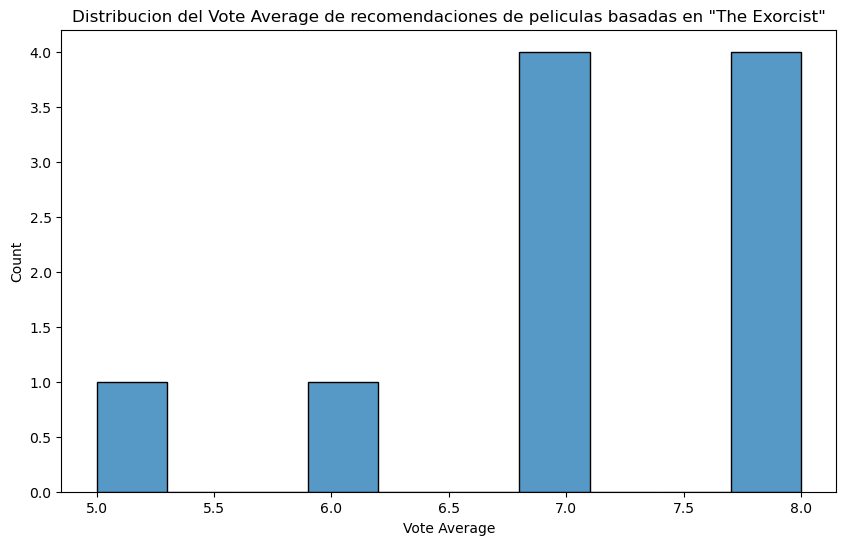

In [42]:
#Aqui podemos ver la distribución de votos de las películas recomendadas para "The Exorcist".

def plot_recommended_movie_scores(title):
    recommended_movies = improved_recommendations(title)
    plt.figure(figsize=(10, 6))
    sns.histplot(recommended_movies['vote_average'], bins=10, kde=False)
    plt.title(f'Distribucion del Vote Average de recomendaciones de peliculas basadas en "{title}"')
    plt.xlabel('Vote Average')
    plt.ylabel('Count')
    plt.show()

plot_recommended_movie_scores('The Exorcist')


<h1>Filtro colaborativo</h1>

In [46]:
#Importa módulos necesarios de la biblioteca Surprise y cargo el dataset ratings_small.csv

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import pandas as pd

reader = Reader(rating_scale=(1, 5))
ratings = pd.read_csv('ratings_small.csv')

ratings.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [48]:
min_rating = ratings.min()
max_rating = ratings.max()
print(min_rating, max_rating)

userId               1.0
movieId              1.0
rating               0.5
timestamp    789652009.0
dtype: float64 userId       6.710000e+02
movieId      1.639490e+05
rating       5.000000e+00
timestamp    1.476641e+09
dtype: float64


In [45]:
#Busco los mejores parametros para SVD

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

smaller_ratings = ratings.sample(frac=0.6)

# Cargar el subconjunto de datos en Surprise
data = Dataset.load_from_df(smaller_ratings[['userId', 'movieId', 'rating']], reader)

# Definir el espacio de parámetros
param_grid = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Crear un objeto GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Ajustar datos
# data = ...
gs.fit(data)

# Imprimir los mejores parámetros
print("Mejores parámetros: ", gs.best_params['rmse'])

Mejores parámetros:  {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [49]:
# Uso el algoritmo SVD con parámetros ajustados
algo = SVD(n_factors=200, n_epochs=30, lr_all=0.01, reg_all=0.1) 

# Evaluo el rendimiento del algoritmo usando validación cruzada sin paralelización
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=1)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9108  0.8965  0.9017  0.9030  0.0059  
MAE (testset)     0.7015  0.6948  0.6953  0.6972  0.0031  
Fit time          0.94    0.99    0.97    0.97    0.02    
Test time         0.11    0.11    0.11    0.11    0.00    


In [50]:
#Calificaciones para el usuario con el ID 1
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [56]:
#Prediccion del usuario id1 para la pelicula con Id2, con puntuaqcion conocida de 3

algo.predict(1, 2, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8996616013822685, details={'was_impossible': False})

In [ ]:
#la prediccion de 2.899 es bastante cercana

<h1>Filtro Hibrido<h1>

In [ ]:
# Convertir un valor a numero entero de forma segura. Mas adelante se aplicara.

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
#Creo un mapeo entre los IDs de las películas en Movies y los IDs de TMDB.

id_map = pd.read_csv('links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(movielist[['title', 'id']], on='id').set_index('title')


In [ ]:
#
indices_map = id_map.set_index('id')

In [ ]:
#La función genera una lista de 10 películas,adaptadas específicamente para cada usuario basándose en sus calificaciones anteriores y la similitud de contenido con "Gattaca".

def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movielist.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1058, 'Gattaca')

In [ ]:
hybrid(100, 'Gattaca')

In [ ]:
hybrid(112, 'Gattaca')

In [ ]:
#Aun cambiando usuario genera resultados bastante similares